In [1]:
import numpy as np
import cv2 as cv #opencv - for reading in images
# import os
import data_processing as dp
import storage as tst
import scipy.interpolate as intp
import scipy.fft as fft
from functools import partial
import vanilla_frog as frg
import matplotlib.pyplot as plt
import matplotlib.image as img
import matplotlib as mpl
mpl.rc('xtick', direction='in', top=True)
mpl.rc('ytick', direction='in', right=True)
mpl.rc('xtick.minor', visible=True)
mpl.rc('ytick.minor', visible=True)
%matplotlib inline

# constants
c = 2.99e8 # speed of light in vac [m/s]
# factors for plotting, b/c im working in m and sec
h2th = 1.e-15 # Hz to THz
m2nm = 1.e9 # m to nm
s2fs = 1.e15 # s to fs
rng = np.random.default_rng()

# FROG Testing

### vanilla SHG FROG

NOTES:

    - need to decide on a fft norm convention, i personally kinda like 'ortho', aka 1/sqrt{N} on both
    - when finding freq or times with fft, times needs df (but is just delays), freq needs dt and is going to have the neg freqs obvs
    - calc traces can be float, but shouldnt be <0, figure out whn to implement checks for that
    - using tau-tau for times and should cover pnts on both sides of tau
    - doing these as all seperate functs is for testing and to store in a large funct that will work faster
    -also need to test when complex and neg numbers show up (at some pnt they have to cuz the output E field is complex)
    ^ will need all functions to handle complex numbers 
    - will at some point may want to try and get FT and IFT steps handle padding
    - need to figure out what FT style i should use, it needs to stay consistent
    - ^ spectra should be on the carrier freq, but that ignores the neg freq components
    - see if once i finish putting this shit in a .py file i can do the compiling decorator again and give this shit a speed boost
    - so the E(t) removes the carier freq omega_0, but FT{E} is centered on omega_0 but only contains the positive part. but this is specificallly for after frog
    - use numpy sum for integrals like in creating new iter of E, might wanna do like a partial for it since its already a funct
    - ^ to save mem from importing another mod, just use numpy tabulated integration methods
    - in full program gonna wanna do some sort of check against prev Gk's, maybe use np.diff to check for stagnation
    - in full program, want to pre-load the signal arr's
    - in full program should either take carrier freq as input or calc in program
    - normalize measured trace to unity
    - for creating E_k+1, using trapz is fine, but do i want to include the actual dx cuz it makes the values dummy low?
    - going to want to double check the ft_freq and ift_time with f_arr and d_arr

fft is centered at 0 so measured frog center freq needs to be shifted to 0, to do that all youd need to do is make sure your carrier freq is the middle

the real reason we need this is because we need the freqs to technically 'line up' during the apply frog step, $\tilde{E}'_{sig}(\omega,\tau)$ eqn doesnt make any sense if the omega's dont line up

might also want to start with full real E field guess since that ought to center at 0

going to try:
    - fuck it see what happens, just run the process on this crap data, and current guess
    - make up a pulse (use real E field eqn to make it, 1032 nm, 77 fs) then see if you shit actually works 

AS EXPECTED, the fuckin calibration was wrong, although im pretty sure i got the axis right, id need to double check tho, talk to like yassen/liam and do a guesstimate for these guys i guess, once you have a guess for raw pharos (where id start) check its TBP (time-bandwidth prod) and make sure itll actually 

tbh need to go back to doing making and testing my shit the old fashioned way and fuckin just do it on the fuckin data

can just make E fields up and then just add noise, and see how she does

functs needed:

    - sep funct for all the diff steps in FROG algorithm
        * handle padding zeros in FT steps if desired
    - overall funct to take in the processed data and do all the frog shit
    - calc marginals
    - funct for phase wrapping (0<phi<2*pi) and blanking (whn I~0)
    - ^ np.unwrap for wrapping
    - funct to check the spectral intensity and phase (needs the real E)
    - and a funct to convert from spectral intensity of freq to wvl
    - funct to shake out of local min and/or dont let err go back up
    - ^ would wanna do this in apply frog step??
    - add decorators

need this for vanilla frog and GP, at some point we'll get to the hybrid algorithms and GPCP (or whatever its called)

want to latex the process up here, not just to show the bois but also so i have my conventions written down too
$$I_{FROG}(\omega,\tau) = \left| \tilde{E}_{sig}(\omega,\tau) \right|^2$$

$$E_{sig}(t,\tau) \approx E(t) E(t-\tau)$$

$$\tilde{E}'_{sig}(\omega,\tau) = \frac{\tilde{E}_{sig}(\omega,\tau)}{\left| \tilde{E}_{sig}(\omega,\tau) \right|} \sqrt{I_{FROG}(\omega,\tau)}$$

$$E^{(k+1)}(t) = \int^{\infty}_{\infty} \mathrm{d}\tau \ E^{(k)}_{sig}(t,\tau)$$

$$ G^{(k)} = \sqrt{ \frac{1}{N^2} \sum^{N}_{\mathrm{i,j}} \left| I_{FROG}(\omega_i,\tau_j) - \mu I^{(k)}_{FROG}(\omega_i ,\tau_j ) \right|^2 }$$

$$ \mu = \frac{ \sum^{N}_{\mathrm{i,j}} I_{FROG}(\omega_i,\tau_j) I^{(k)}_{FROG}(\omega_i ,\tau_j )}{ \sum^{N}_{\mathrm{i,j}} I^{(k)}_{FROG}(\omega_i ,\tau_j ) I^{(k)}_{FROG}(\omega_i ,\tau_j ) } $$

indexing conv: for $t_i$,$\omega_i$ they are on vert with $\mathrm{i} = 0,1,\ldots,N$, $\tau_j$ is on horz with $\mathrm{j} = 0,1,\ldots,N$, and for $I(\omega_0 , \tau_0 )$ that is the 0th,0th element and also corresponds to the 0th element of all the arrays too

eqns to add
marginals chap 10

convergence chap 9 eqn 9, dont need this for full algorithm but good for testing to see if you can cut thru noise

In [2]:
# load the bois
folder = './Raw_PHAROS_output/'
f1 = './first_stage_output/'
f2 = './second_stage_output/'
trc = np.genfromtxt(folder+'128-bit-test_processed_trace.txt',dtype=np.ushort,delimiter=',',encoding='utf-8')
d_arr = np.genfromtxt(folder+'128-bit-test_processed_delay.txt',delimiter=',',encoding='utf-8')
f_arr = np.genfromtxt(folder+'128-bit-test_processed_freq.txt',delimiter=',',encoding='utf-8')
trc1 = np.genfromtxt(f1+'128-bit_test_processed_trace.txt',dtype=np.ushort,delimiter=',',encoding='utf-8')
d1 = np.genfromtxt(f1+'128-bit_test_processed_delay.txt',delimiter=',',encoding='utf-8')
f1 = np.genfromtxt(f1+'128-bit_test_processed_freq.txt',delimiter=',',encoding='utf-8')
trc2 = np.genfromtxt(f2+'128-bit_processed_trace.txt',dtype=np.ushort,delimiter=',',encoding='utf-8')
d2 = np.genfromtxt(f2+'128-bit_processed_delay.txt',delimiter=',',encoding='utf-8')
f2 = np.genfromtxt(f2+'128-bit_processed_freq.txt',delimiter=',',encoding='utf-8')

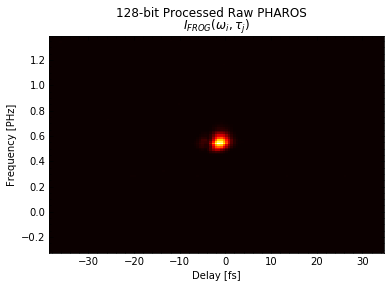

In [3]:
tst.rough_plot(trc,d_arr,f_arr,title='128-bit Processed Raw PHAROS')

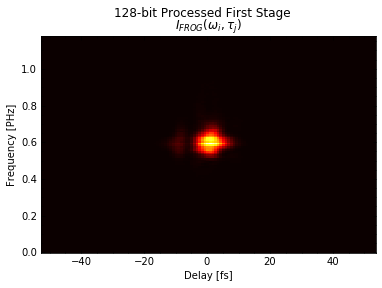

In [4]:
tst.rough_plot(trc1,d1,f1,title='128-bit Processed First Stage')

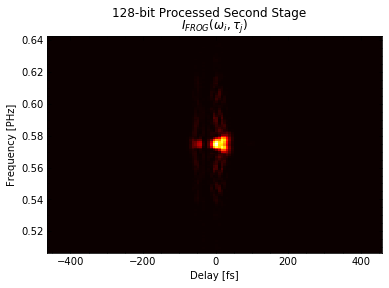

In [5]:
tst.rough_plot(trc2,d2,f2,title='128-bit Processed Second Stage')

In [187]:
# useful params of trace/arrays, dt,df,N,etc
N = trc.shape[0] # trace dim, NxN
dt = np.diff(d_arr)[0] # delay spacing btwn pnts [s]
df = np.diff(f_arr)[0] # freq spacing btwn pnts [Hz]

going to get messy and do a hard coded run thru the frog loop here and edit the functions below

the functions, keep frog testing above this cell

this is the testing of the actual algorithm below here

will want to do time it at some point

In [49]:
# what do we need: m_trace, inital guess, max_iter, g val for converge
# eventually: dt, df, might want N
def basic_frog(m_trace,E0,delay,max_iter,min_g):
    '''
    vanilla pulse retreval algorithm
    
    inputs:
    m_trace - normalized? or normalize within
    E0 - inital guess
    delay - d_arr
    max_iter - 
    min_g - have default ~10^-3
    output: tuple in this order
    Ef - retrived pulse
    ret_trace - retrived trace
    G - array of g err, holds no zeros if algorithm finishes before max_iter
    '''
    # asserts
    # allocate
    mtrc = m_trace.astype(float)/m_trace.max()
    G_err = np.zeros(max_iter) # array holding g err's, for now
    N = m_trace.shape[0] # should be NxN
    Ef = np.zeros(N,dtype=complex) # final retrived E(t)
    ret_trace = np.zeros((N,N)) # trace of final iterations ftEs_p
    # counter
    k = 0
    # while loop for algorithm
    while (k<max_iter):
        # allocate all arrays (so they reset ea time) and if for E_guess 
        if (k==0):
            Ek = E0
        else:
            Ek = E_kp1
        Es = np.zeros((N,N),dtype=complex) # Esig(t,tau)
        ftEs = np.zeros((N,N),dtype=complex) # Esig(omega,tau)
        c_trace = np.zeros((N,N)) # calc Ifrog(omega,tau)
        ftEs_p = np.zeros((N,N),dtype=complex) # Esig(omega,tau) after applying measured frog
        Es_p = np.zeros((N,N),dtype=complex) # Esig'(t,tau)
        E_kp1 = np.zeros(N,dtype=complex) #Ek+1(t)
        # gen signal
        Es = pulse2sig(Ek,delay)
        # FT
        ftEs = FTsig(Es)
        # calc trace
        c_trace = sig2trc(ftEs)
        c_trace /= c_trace.max()
        # apply frog, calc gk
        ftEs_p = apply_frog(ftEs,mtrc)
        G_err[k] = g_err(mtrc,c_trace)
        Es_p = IFTsig(ftEs_p)
        E_kp1 = gen_Ekp1(Es_p)
        # check converge condits and break loop if done
        print('for iteration: ',k+1,', g = ',G_err[k]) # dont know if i want this
        if (G_err[k]<=min_g):
            print('Yay pulse retrived in ',k+1,' iterations!')
            break
        # incroment k, must be last thing
        k += 1
    # max iter reached, give the people their values
    G = np.zeros(k+1) # G error array that you get to keep
    G = G_err[:k]
    ret_trace = sig2trc(ftEs_p)
    Ef = E_kp1
    return (Ef,ret_trace,G)

In [ ]:
# hidden cell is basic_frog outside of its funct for testing

In [213]:
# testing outside of funct
# allocate
G_err = np.zeros(max_iter) # array holding g err's, for now
# N = m_trace.shape[0] # should be NxN
Ef = np.zeros(N,dtype=complex) # final retrived E(t)
ret_trace = np.zeros((N,N)) # trace of final iterations ftEs_p
# counter
k = 0
# while loop for algorithm
while (k<max_iter):
    # allocate all arrays (so they reset ea time) and if for E_guess 
    if (k==0):
        Ek = E0
    else:
        Ek = E_kp1
    Es = np.zeros((N,N),dtype=complex) # Esig(t,tau)
    ftEs = np.zeros((N,N),dtype=complex) # Esig(omega,tau)
    c_trace = np.zeros((N,N)) # calc Ifrog(omega,tau)
    ftEs_p = np.zeros((N,N),dtype=complex) # Esig(omega,tau) after applying measured frog
    Es_p = np.zeros((N,N),dtype=complex) # Esig'(t,tau)
    E_kp1 = np.zeros(N,dtype=complex) #Ek+1(t)
    # gen signal
    Es = pulse2sig(Ek,d_arr)
    # FT
    ftEs = FTsig(Es)
    # calc trace
    c_trace = sig2trc(ftEs)
    # apply frog, calc gk
    ftEs_p = apply_frog(ftEs,trc)
    G_err[k] = g_err(trc,c_trace)
    Es_p = IFTsig(ftEs_p)
    E_kp1 = gen_Ekp1(Es_p)
    # check converge condits and break loop if done
    print('for iteration: ',k+1,', g = ',G_err[k]) # dont know if i want this
    if (G_err[k]<=min_g):
        print('Yay pulse retrived in ',k+1,' iterations!')
        break
    # incroment k, must be last thing
    k += 1
# loop over, give the people their values
G = np.zeros(k+1) # G error array that you get to keep
G = G_err[:k]
ret_trace = sig2trc(ftEs_p)
Ef = E_kp1

C:\Users\afish\.conda\envs\ml_env\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


for iteration:  1 , g =  2.9946954241774386
for iteration:  2 , g =  2.1564350703713915
for iteration:  3 , g =  2.158675987973308
for iteration:  4 , g =  2.159267624325867
for iteration:  5 , g =  2.1595955996940996
for iteration:  6 , g =  2.1589087023009434
for iteration:  7 , g =  2.158188266549191
for iteration:  8 , g =  2.156802043152134
for iteration:  9 , g =  2.1532971158503456
for iteration:  10 , g =  2.148272242553711
for iteration:  11 , g =  2.1413497602938345
for iteration:  12 , g =  2.131849486821139
for iteration:  13 , g =  2.124899512896585
for iteration:  14 , g =  2.125157356580267
for iteration:  15 , g =  2.1233334079717436
for iteration:  16 , g =  2.1185804193009496
for iteration:  17 , g =  2.1169548063068615
for iteration:  18 , g =  2.117504823240557
for iteration:  19 , g =  2.115926333586906
for iteration:  20 , g =  2.117326141645452
for iteration:  21 , g =  2.1172409464132707
for iteration:  22 , g =  2.1179562129763356
for iteration:  23 , g =  2.11

In [211]:
# never gonna use but has a good plot format on it
# fig = plt.figure(figsize=(6,6));
# gs = fig.add_gridspec(2,1,hspace=.2)
# reax = fig.add_subplot(gs[0,0])
# imax = fig.add_subplot(gs[1,0],sharex=reax)
# reax.plot(d_arr*s2fs,Ef.real);
# imax.plot(d_arr*s2fs,Ef.imag);
# imax.set_xlabel('time [fs]');
# reax.set_ylabel('Amp (a.u.)');
# reax.set_title('Re{E}');
# imax.set_ylabel('Amp (a.u.)');
# imax.set_title('Im{E}');
# fig.suptitle('retrived E field');

keep algorithm testing above here

In [34]:
# start just making functions for each step
def apply_frog(ftEs,m_trace):
    '''
    applies the measured FROG trace to the current iteration's generated E_sig(omega,tau) to generate the improved E'_sig(omega,tau), aka eqn 8.4 in Trebino's book
    this is the general function but within my overal FROG algorithm, it will be utilized with a partial funct
    inputs:
    ftEs -
    m_trace - 
    outputs:
    ftEs_p - 
    '''
    # asserts (later) shape must be same
    # need to make a list comp becuase if any vals of ftEs are 0 its gonna throw nans
    af = np.zeros_like(ftEs)
    af = (ftEs/np.abs(ftEs))*np.sqrt(m_trace)
    ftEs_p = np.array([[af[i,j] if (ftEs[i,j]!=0) else 0. for j in range(af.shape[0])] for i in range(af.shape[0])])
    return ftEs_p
# this will be in the main funct
af = partial(apply_frog,m_trace=trc)
af.__doc__ = 'funct apply_frog, but partial-ed to specific trace being used'

In [35]:
def pulse2sig(pulse,delay):
    '''
    takes the pulse E(t) and returns the time-domain SHG signal, Esig(t,tau)
    NOTE: dont need time b/c using tau-tau will cover all the time vals
    inputs:
    pulse - 
    delay - 
    output:
    Es - 
    '''
    # asserts (later) len of pulse and delay must be same
    # just allocate space rather than for loops, plus then all the arrays are like trace already
    N = len(delay)
    # tgrid = time-delay grid [s] tgrid_ij = t_i - tau_j
    # gp = gate pulse gp_ij = E(ti-tauj) so [[E(t_i-tau)],[E(t_i+1-tau)],etc]
    # Es = SHG signal Esig(t,tau), t->omega so works the same way
    tgrid = np.array([[delay[i]-delay[j] for j in range(N)] for i in range(N)])
    real_p = intp.InterpolatedUnivariateSpline(delay,pulse.real,ext='zeros') # extrapolations = 0
    imag_p = intp.InterpolatedUnivariateSpline(delay,pulse.imag,ext='zeros')
    gp = np.array([[(real_p(tgrid[i,j]) + 1.j*imag_p(tgrid[i,j])) for j in range(N)] for i in range(N)])
    # ^ dont matter if pnts are ordered whn eval spl, but even if it did, doesnt matter like this
    Es = np.array([[pulse[i]*gp[i,j] for j in range(N)] for i in range(N)],dtype=complex)
    return Es

In [36]:
def FTsig(Es):
    '''
    go from Esig(t,tau) to Esig(omega,tau) via a 1-d FT
    NOTE: using ortho FT convention
    CURRENTLY (8/11/22) DOESNT handle padding with extra zeros, so i would recommend not
    input:
    Es -
    CURRENTLY NOT GIVING BACK FFT.FREQ ARRAY (10/10/22)
    dt - 
    N - 
    output: tuple in that order
    ftEs - 
    ft_freq - not the same as the processed freqs (f_arr)
    '''
    # assert, idk yet
    ftEs = fft.fftshift(fft.fft(Es,axis=0,norm='ortho'),axes=0)
    # ft_freq = fft.fftshift(fft.fftfreq(N,dt))
    return ftEs
#     return (ftEs,ft_freq)


In [37]:
def IFTsig(ftEs_p):
    '''
    go from ftEsig'(omega,tau) to Esig'(t,tau) after applying measured FROG trace, via a 1-d IFT
    NOTE: using ortho FT convention
    CURRENTLY (8/11/22) DOESNT handle padding with extra zeros, do not use like that
    input:
    ftEs_p - 
    CURRENTLY NOT GIVING BACK FFT.FREQ ARRAY (10/10/22)
    dw - 
    N - 
    output: tuple in this order
    Es_p - 
    ift_time - array, Nx1 - arr of times from IFT
    '''
    # asserts, idk yet
    # need to undo fft.fftshift b/c ift expects direct output from ft
    Es_p = fft.ifft(fft.ifftshift(ftEs_p,axes=0),axis=0,norm='ortho')
    # ift_time = fft.fftshift(fft.fftfreq(N,dw))
    return Es_p
#     return (Es_p,ift_time)

In [38]:
def sig2trc(ftEs):
    '''
    computes the kth calculated trace from the kth Es(omega,tau) for use in G error
    not partial'ed b/c ftEs changes every iteration and is only input
    input:
    ftEs - 
    output:
    c_trace - 
    '''
    return np.abs(ftEs)**2
# might want to call this funct within others, unsure currently

In [39]:
def g_err(m_trace,c_trace):
    '''
    calculated the G error for the kth iteration of the FROG algorithm
    this quantity will be the error that defines convergence and will cause the overall program to stop once it gets low enough
    calls mu_factor within funct
    inputs:
    m_trace - 
    c_trace - 
    outputs:
    Gk - 
    '''
    # assert, trace shapes (if not in mu_factor)
    # get factors
    N = m_trace.shape[0]
    mu = mu_factor(m_trace,c_trace)
    # calc gk
    # asssert that gk will stay real either before w/ stuff in sum or after w/ dtype check
    gk = np.abs(np.sum((m_trace - mu*c_trace))/(N**2))
    return gk

In [40]:
def mu_factor(m_trace,c_trace):
    '''
    calculates the scale factor, mu, for the kth iteration of the FROG algorithm
    NOTE: currently (8/15/22), as i understand, this is to be re-calculated for every iteration, this may change as my understanding changes
    inputs:
    m_trace - 
    c_trace - 
    outputs:
    mu_k - 
    '''
    # assertions, trace shapes
    # does np.sum do the right kind of summation, i feel like it may not
    # should i be using np functions or the python magic symbols (check google i guess)
    mu_k = np.divide(np.sum(np.multiply(m_trace,c_trace)),np.sum(np.multiply(c_trace,c_trace)))
    return mu_k

In [41]:
def gen_Ekp1(Es_p):
    '''
    generates the k+1th E(t) from the kth E'(t,tau) to be used as the pulse in the k+1th FROG cycle
    this is a funct that will be utilized within main program, so it will be partialed
    inputs:
    Es_p - 
    dtau - float
    OR
    delays - array
    NOTE: using np.trapz, can use array or spacing or array, since delays is evenly spaced i wanna go w/ just having spacing since i should probs alrdy have tht
    outputs:
    Ekp1 - 
    '''
    # asserts: if array then check shapes
    # trapz reduces dim of array since it sums along an axis, since delays are horz values need axis=1
    # CURRENTLY NOT GOING TO INCLUDE DX=DTAU, b/c it makes it hella small
    # np.trapz(Es_p,dx=dt,axis=1) # or could do x=d_arr
    return np.trapz(Es_p,axis=1)

In [48]:
def IP(E,I_lim):
    '''
    takes a complex E field and returns the intensity and phase of the field
    this handles the phase wrapping and blanking needed to make a decend plot
    inputs:
    E - 
    I_lim - float - intensity limit after which youd like phase blanking to occur
    outputs: tuple in this order
    I - 
    phi - 
    '''
    # asserts, needs to be complex or handle shit that isnt
    I = frg.sig2trc(E)
    I /= I.max()
    # I = sig2trc(E) # when put into script
    # well figure out if this needs the neg sign once this actually works
    # ang = np.unwrap(np.angle(E)) # handles unwrapping
    ang = np.unwrap(np.arctan2(E.imag,E.real))
    phi = np.array([ang[i] if I[i]>I_lim else 0. for i in range(len(E))]) # handles blanking
    return (I,phi)

testing how to make a good test trace below 

In [212]:
# rng to fuck up the 'true' pulse
# rng = np.random.default_rng()
N = 128
alpha = .1 # noise fract
etaij = rng.poisson(lam=1.,size=(N,N))
mij = rng.normal(size=(N,N))
# ig = rng.random(N).astype(complex) # initial guess for E(t), does it need to be complex?

In [95]:
# wvl = 1032 nm omega = .2904 PHz, pulse width = 77 fs, no phase
N = 128
f0 = .2904*s2fs # carrier freq PHz
dtst = np.linspace(-75.,75.,num=N)*h2th
dt = np.diff(dtst)[0]
ftst = fft.fftshift(fft.fftfreq(N,dt))
df = 1./dt
Imax = np.sqrt(trc.max())*.5
ge = np.exp(-((dtst*s2fs)**2)/200.) # guassian envelope
cw = np.exp(1j*f0*dtst) # carrier wave
E_true = (cw)*np.array([ge[i] if ge[i]>1.e-10 else 0. for i in range(N)],dtype=complex)
# need amp and phase
(ti_true,tphi_true) = frg.IP(E_true,.001)
# amp_true = frg.sig2trc(E_true)
# tphi = np.unwrap(-1.*np.arctan2(E_true.imag,E_true.real))
# tphi_true = np.array([tphi[i] if amp_true[i]>1.e-5 else 0. for i in range(N)])
# create true trace
es_true = frg.pulse2sig(E_true,dtst)
ftes_true = frg.FTsig(es_true)
# ftes_true = fft.fftshift(fft.fft(es_true,axis=0,norm='ortho'),axes=0)
trc_true = frg.sig2trc(ftes_true)
trc_true /= trc_true.max()
# fuck it up girlie
eta = (etaij*alpha)/etaij.max()
# m = 1.+mij*alpha
# trc_noise = trc_true*m
trc_noise = trc_true + eta
trc_noise -= np.mean(trc_noise)
# fix it up girlie
# bnd_val = (10./s2fs,-25./s2fs,-.25/h2th,.25/h2th)
# avg_removal is being weird cuz it aint ints
# trc_inp = tst.avg_removal(trc_noise,dtst,ftst,bnd_val,trace_type=np.float64)
trc_inp = np.array([[(trc_noise[i,j]) if trc_noise[i,j]>0. else 0. for j in range(N)] for i in range(N)])
# trc_inp = trc_noise - np.mean(trc_noise)
# get spectral amp/phase
ftE_true = fft.fftshift(fft.fft(E_true,norm='ortho'))
(si_true,sphi_true) = frg.IP(ftE_true,.001)

In [8]:
# plt.plot(dtst*s2fs,E_true.real);
# plt.plot(dtst*s2fs,E_true.imag);
# plt.figure();
# plt.plot(dtst*s2fs,ti_true);
# plt.figure();
# plt.plot(dtst*s2fs,tphi_true,'r.');

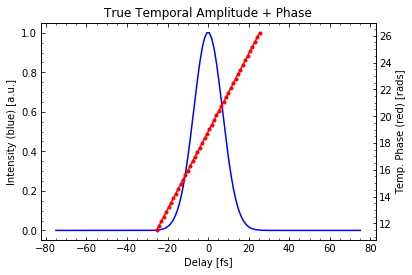

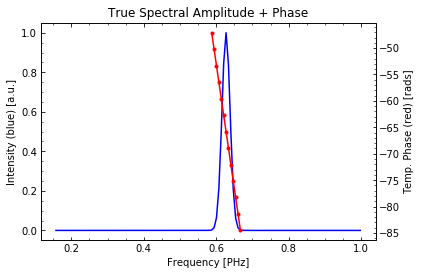

In [9]:
plt.figure();
ax1 = plt.subplot();
intf = ax1.plot(dtst*s2fs,ti_true,'b')
ax2 = ax1.twinx();
phif = ax2.plot(dtst[tphi_true!=0.]*s2fs,tphi_true[tphi_true!=0.],'r.-')
ax1.set_xlabel('Delay [fs]')
ax1.set_ylabel('Intensity (blue) [a.u.]')
ax2.set_ylabel('Temp. Phase (red) [rads]');
ax1.set_title('True Temporal Amplitude + Phase');
plt.figure();
ax1 = plt.subplot();
intf = ax1.plot(f0*2*h2th+ftst*h2th,si_true,'b')
ax2 = ax1.twinx();
phif = ax2.plot(f0*2*h2th+ftst[sphi_true!=0.]*h2th,sphi_true[sphi_true!=0.],'r.-')
ax1.set_xlabel('Frequency [PHz]')
ax1.set_ylabel('Intensity (blue) [a.u.]')
ax2.set_ylabel('Temp. Phase (red) [rads]');
ax1.set_title('True Spectral Amplitude + Phase');

In [10]:
# plt.pcolormesh(dtst*s2fs,dtst*s2fs,es_true.real)

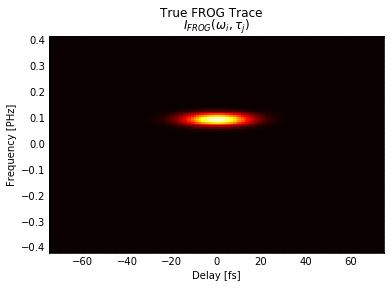

In [11]:
# plt.pcolormesh(dtst*s2fs,ftst*h2th,trc_true);
tst.rough_plot(trc_true,dtst,ftst,title='True FROG Trace')

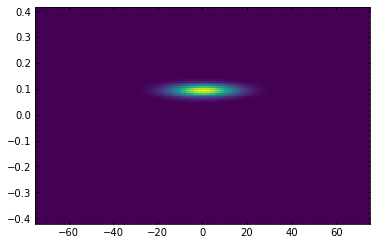

In [12]:
plt.pcolormesh(dtst*s2fs,ftst*h2th,trc_inp);

In [15]:
max_iter = 20
min_g = .0001
Erand = rng.random(N).astype(complex)

In [16]:
(Ef,rtrc,G) = frg.basic_frog(trc_inp,Erand,dtst,max_iter,min_g)

for iteration:  1 , g =  0.007343893547638665
for iteration:  2 , g =  0.007515261571755068
for iteration:  3 , g =  0.0072475410314989195
for iteration:  4 , g =  0.0071786973366804755
for iteration:  5 , g =  0.00710319768992448
for iteration:  6 , g =  0.007134049062213605
for iteration:  7 , g =  0.007121762613545894
for iteration:  8 , g =  0.0070812365964397226
for iteration:  9 , g =  0.007080208014823641
for iteration:  10 , g =  0.007077729606706476
for iteration:  11 , g =  0.00706810778679562
for iteration:  12 , g =  0.007067008222661554
for iteration:  13 , g =  0.007066674682144314
for iteration:  14 , g =  0.007064773584530832
for iteration:  15 , g =  0.00706442638827549
for iteration:  16 , g =  0.007064395938275615
for iteration:  17 , g =  0.0070640392587645534
for iteration:  18 , g =  0.007063948593556468
for iteration:  19 , g =  0.007063947889379084
for iteration:  20 , g =  0.007063882620488568


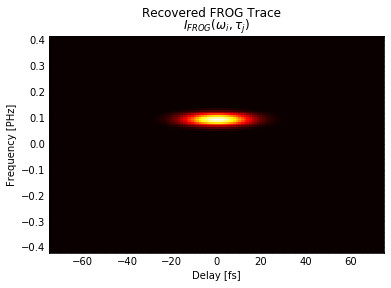

In [17]:
# plt.pcolormesh(rtrc);
tst.rough_plot(rtrc,dtst,ftst,title='Recovered FROG Trace')

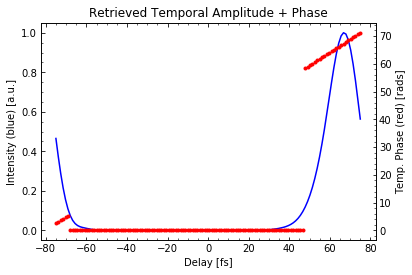

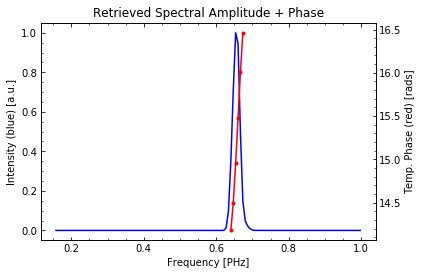

In [18]:
# plt.plot(Ef.real);
# plt.plot(Ef.imag);
(tif,tphif) = frg.IP(Ef,.1)
(sif,sphif) = frg.IP(fft.fftshift(fft.fft(Ef,norm='ortho')),.1)
plt.figure();
ax1 = plt.subplot();
intf = ax1.plot(dtst*s2fs,tif,'b')
ax2 = ax1.twinx();
phif = ax2.plot(dtst*s2fs,tphif,'r.')
ax1.set_xlabel('Delay [fs]')
ax1.set_ylabel('Intensity (blue) [a.u.]')
ax2.set_ylabel('Temp. Phase (red) [rads]');
ax1.set_title('Retrieved Temporal Amplitude + Phase')
plt.figure();
ax1 = plt.subplot();
intf = ax1.plot(2*f0*h2th+ftst*h2th,sif,'b')
ax2 = ax1.twinx();
phif = ax2.plot(2*f0*h2th+ftst[sphif!=0.]*h2th,sphif[sphif!=0.],'r.-')
ax1.set_xlabel('Frequency [PHz]')
ax1.set_ylabel('Intensity (blue) [a.u.]')
ax2.set_ylabel('Temp. Phase (red) [rads]');
ax1.set_title('Retrieved Spectral Amplitude + Phase');

In [20]:
# wvl = 1032 nm omega = .2904 PHz, pulse width = 50 fs, linear chirp phase
N = 256
f0 = .2904*s2fs # carrier freq PHz
dtst = np.linspace(-30.,30.,num=N)*h2th
dt = np.diff(dtst)[0]
ftst = fft.fftshift(fft.fftfreq(N,dt))
df = 1./dt
Imax = np.sqrt(trc.max())*.5
cw = np.exp(1j*f0*dtst) # carrier wave
b = .032*(s2fs**2) # rad/s^2 phase
a = 1./(10.**2) # thing related to pulse duration
ge = np.exp(-a*(dtst*s2fs)**2)*np.exp(1j*b*(dtst*s2fs)**2)
E_true = np.array([ge[i] if np.abs(ge[i])>1.e-20 else 0. for i in range(N)])
# amp and phase
(ti_true,tphi_true) = frg.IP(E_true,1.e-1)
# create true trace
es_true = frg.pulse2sig(E_true,dtst)
ftes_true = frg.FTsig(es_true)
# ftes_true = fft.fftshift(fft.fft(es_true,axis=0,norm='ortho'),axes=0)
trc_true = frg.sig2trc(ftes_true)
trc_true /= trc_true.max()
# fuck it up girlie
eta = (etaij*alpha)/etaij.max()
# m = 1.+mij*alpha
trc_noise = trc_true + eta
trc_noise -= np.mean(trc_noise)
# trc_noise += eta
# fix it up girlie
# bnd_val = (10./s2fs,-25./s2fs,-.25/h2th,.25/h2th)
# avg_removal is being weird cuz it aint ints
# trc_inp = tst.avg_removal(trc_noise,dtst,ftst,bnd_val,trace_type=np.float64)
# trc_inp = trc_noise - np.mean(trc_noise)
trc_inp = np.array([[(trc_noise[i,j]) if trc_noise[i,j]>0. else 0. for j in range(N)] for i in range(N)])
# get spec amp/phase
ftE_true = fft.fftshift(fft.fft(E_true,norm='ortho'))
(si_true,sphi_true) = frg.IP(ftE_true,.1)

In [21]:
# plt.plot(dtst*s2fs,E_true.real,'b.-');
# # plt.figure();
# # plt.plot(dtst*s2fs,ge.real,'b.-');
# # plt.figure();
# # plt.plot(dtst*s2fs,E_true.imag,'r.-');
# plt.figure();
# plt.plot(dtst*s2fs,ti_true);
# plt.figure();
# plt.plot(dtst*s2fs,tphi_true,'r.-');

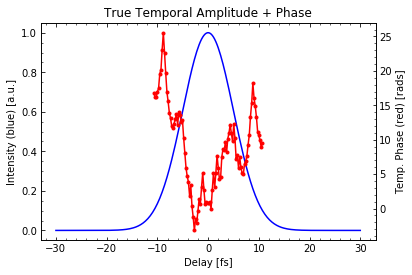

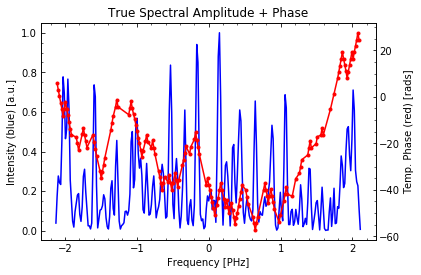

In [22]:
plt.figure();
ax1 = plt.subplot();
intf = ax1.plot(dtst*s2fs,ti_true,'b')
ax2 = ax1.twinx();
phif = ax2.plot(dtst[tphi_true!=0.]*s2fs,tphi_true[tphi_true!=0.],'r.-')
ax1.set_xlabel('Delay [fs]')
ax1.set_ylabel('Intensity (blue) [a.u.]')
ax2.set_ylabel('Temp. Phase (red) [rads]');
ax1.set_title('True Temporal Amplitude + Phase');
plt.figure();
ax1 = plt.subplot();
intf = ax1.plot(ftst*h2th,si_true,'b')
ax2 = ax1.twinx();
phif = ax2.plot(ftst[sphi_true!=0.]*h2th,sphi_true[sphi_true!=0.],'r.-')
ax1.set_xlabel('Frequency [PHz]')
ax1.set_ylabel('Intensity (blue) [a.u.]')
ax2.set_ylabel('Temp. Phase (red) [rads]');
ax1.set_title('True Spectral Amplitude + Phase');

C:\Users\afish\.conda\envs\ml_env\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


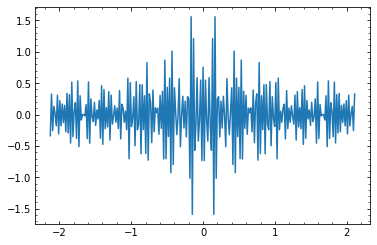

In [23]:
plt.plot(ftst*h2th,fft.fftshift(fft.fft(E_true+E_true.conj(),norm='ortho')));

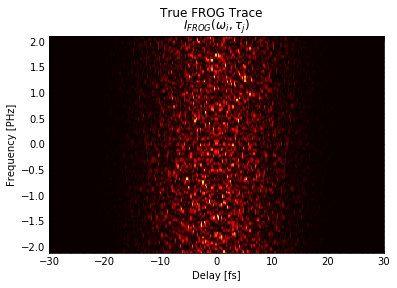

In [24]:
# plt.pcolormesh(dtst*s2fs,ftst*h2th,trc_true);
tst.rough_plot(trc_true,dtst,ftst,title='True FROG Trace')

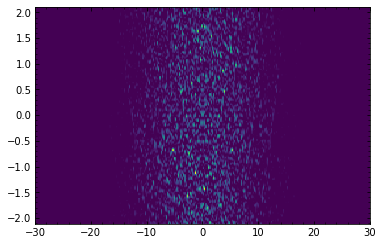

In [25]:
plt.pcolormesh(dtst*s2fs,ftst*h2th,trc_inp);

In [26]:
max_iter = 20
min_g = .01
Erand = rng.random(N).astype(complex)

In [27]:
(Ef_1,rtrc_1,G_1) = frg.basic_frog(trc_true,Erand,dtst,max_iter,min_g)

for iteration:  1 , g =  0.040446967370069614
for iteration:  2 , g =  0.02087284333052407
for iteration:  3 , g =  0.017626170660452533
for iteration:  4 , g =  0.018692233134149527
for iteration:  5 , g =  0.01907588497748999
for iteration:  6 , g =  0.018618487837416875
for iteration:  7 , g =  0.01786740359063565
for iteration:  8 , g =  0.01724973494939014
for iteration:  9 , g =  0.016821636884485913
for iteration:  10 , g =  0.016634654450323253
for iteration:  11 , g =  0.016581953055183677
for iteration:  12 , g =  0.016843480130422236
for iteration:  13 , g =  0.017190214124580043
for iteration:  14 , g =  0.017393097125017548
for iteration:  15 , g =  0.017222723943851072
for iteration:  16 , g =  0.01706631857881326
for iteration:  17 , g =  0.017317961224817754
for iteration:  18 , g =  0.01721899844345526
for iteration:  19 , g =  0.017060566012788884
for iteration:  20 , g =  0.017277767087513312


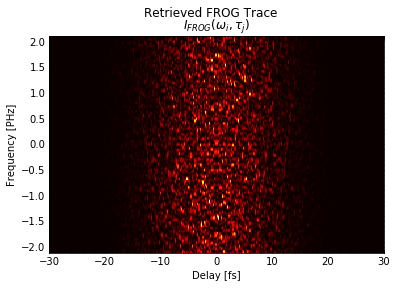

In [28]:
# plt.pcolormesh(rtrc_1);
tst.rough_plot(rtrc_1,dtst,ftst,title='Retrieved FROG Trace')

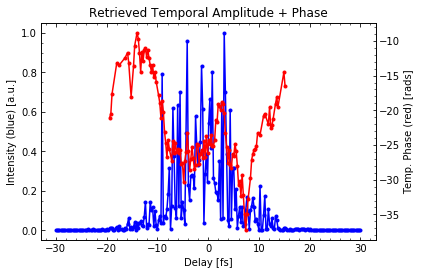

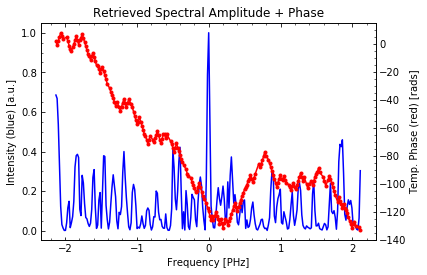

In [29]:
# plt.plot(Ef_1.real);
# plt.figure();
# plt.plot(Ef_1.imag);
(tif,tphif) = frg.IP(Ef_1,0.01)
(sif,sphif) = frg.IP(fft.fftshift(fft.fft(Ef_1,norm='ortho')),.01)
plt.figure()
ax1 = plt.subplot();
intf = ax1.plot(dtst*s2fs,tif,'b.-')
ax2 = ax1.twinx();
phif = ax2.plot(dtst[tphif!=0.]*s2fs,tphif[tphif!=0.],'r.-')
ax1.set_xlabel('Delay [fs]')
ax1.set_ylabel('Intensity (blue) [a.u.]')
ax2.set_ylabel('Temp. Phase (red) [rads]');
ax1.set_title('Retrieved Temporal Amplitude + Phase')
plt.figure();
ax1 = plt.subplot();
intf = ax1.plot(ftst*h2th,sif,'b')
ax2 = ax1.twinx();
phif = ax2.plot(ftst[sphif!=0.]*h2th,sphif[sphif!=0.],'r.-')
ax1.set_xlabel('Frequency [PHz]')
ax1.set_ylabel('Intensity (blue) [a.u.]')
ax2.set_ylabel('Temp. Phase (red) [rads]');
ax1.set_title('Retrieved Spectral Amplitude + Phase');

In [31]:
N = 128
f0 = .2904*s2fs # carrier freq PHz
dtst = np.linspace(-100.,100.,num=N)*h2th
dt = np.diff(dtst)[0]
ftst = fft.fftshift(fft.fftfreq(N,dt))
df = 1./dt
Imax = np.sqrt(trc.max())*.5
ge = np.exp((-(dtst*s2fs)**2)/50.) # envelop
cw = np.exp(1j*f0*dtst) # carrier wave
E_true = np.array([ge[i] if ge[i]>1.e-10 else 0. for i in range(N)],dtype=complex)
# amp and phase
(ti_true,tphi_true) = frg.IP(E_true,.01)
# create true trace
es_true = frg.pulse2sig(E_true,dtst)
# ftes_true = frg.FTsig(es_true)
ftes_true = fft.fftshift(fft.fft(es_true,axis=0,norm='ortho'),axes=0)
trc_true = frg.sig2trc(ftes_true)
trc_true /= trc_true.max()
# fuck it up girlie
eta = (etaij*alpha)/etaij.max()
# m = 1.+mij*alpha
trc_noise = trc_true+eta
trc_noise -= np.mean(trc_noise)
# trc_noise += eta
# fix it up girlie
# bnd_val = (10./s2fs,-25./s2fs,-.25/h2th,.25/h2th)
# avg_removal is being weird cuz it aint ints
# trc_inp = tst.avg_removal(trc_noise,dtst,ftst,bnd_val,trace_type=np.float64)
trc_inp = np.array([[(trc_noise[i,j]) if trc_noise[i,j]>0. else 0. for j in range(N)] for i in range(N)])
# trc_inp = trc_noise - np.mean(trc_noise)
ftE_true = fft.fftshift(fft.fft(E_true,norm='ortho'))
(si_true,sphi_true) = frg.IP(ftE_true,.001)

In [32]:
# plt.figure();
# plt.plot(dtst*s2fs,ti_true);
# plt.figure();
# plt.plot(dtst[tphi_true!=0.]*s2fs,tphi_true[tphi_true!=0.],'r.');

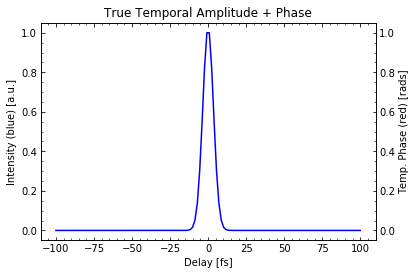

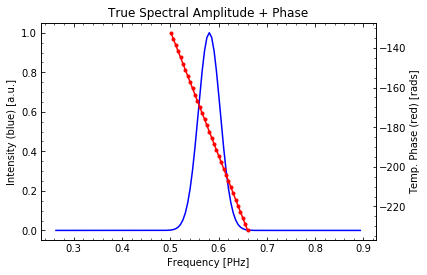

In [33]:
plt.figure();
ax1 = plt.subplot();
intf = ax1.plot(dtst*s2fs,ti_true,'b')
ax2 = ax1.twinx();
phif = ax2.plot(dtst[tphi_true!=0.]*s2fs,tphi_true[tphi_true!=0.],'r.-')
ax1.set_xlabel('Delay [fs]')
ax1.set_ylabel('Intensity (blue) [a.u.]')
ax2.set_ylabel('Temp. Phase (red) [rads]');
ax1.set_title('True Temporal Amplitude + Phase');
plt.figure();
ax1 = plt.subplot();
intf = ax1.plot(f0*2*h2th+ftst*h2th,si_true,'b')
ax2 = ax1.twinx();
phif = ax2.plot(f0*2*h2th+ftst[sphi_true!=0.]*h2th,sphi_true[sphi_true!=0.],'r.-')
ax1.set_xlabel('Frequency [PHz]')
ax1.set_ylabel('Intensity (blue) [a.u.]')
ax2.set_ylabel('Temp. Phase (red) [rads]');
ax1.set_title('True Spectral Amplitude + Phase');

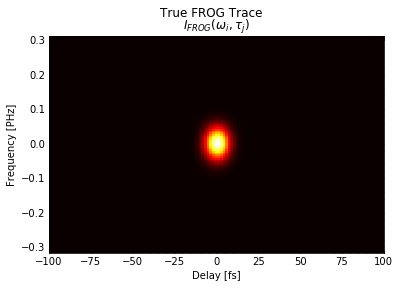

In [34]:
# plt.pcolormesh(dtst*s2fs,ftst*h2th,trc_true);
tst.rough_plot(trc_true,dtst,ftst,title='True FROG Trace')

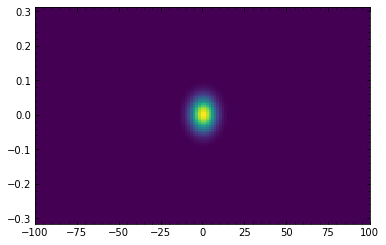

In [35]:
plt.pcolormesh(dtst*s2fs,ftst*h2th,trc_inp);

In [36]:
max_iter = 10
min_g = 1.e-9
Erand = rng.random(N).astype(complex)

In [37]:
(Ef_1,rtrc_1,G_1) = frg.basic_frog(trc_inp,Erand,dtst,max_iter,min_g)

for iteration:  1 , g =  0.005867259093713882
for iteration:  2 , g =  0.000596179703493995
for iteration:  3 , g =  0.002131713540759221
for iteration:  4 , g =  0.0020473226980638284
for iteration:  5 , g =  0.002366489164243967
for iteration:  6 , g =  0.001063475709171161
for iteration:  7 , g =  0.0002491876967961324
for iteration:  8 , g =  0.00022926480165400248
for iteration:  9 , g =  0.00022926231566777207
for iteration:  10 , g =  0.0002292621282472891


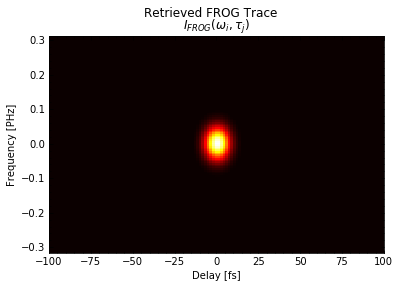

In [38]:
# plt.pcolormesh(rtrc_1)
tst.rough_plot(rtrc_1,dtst,ftst,title='Retrieved FROG Trace')

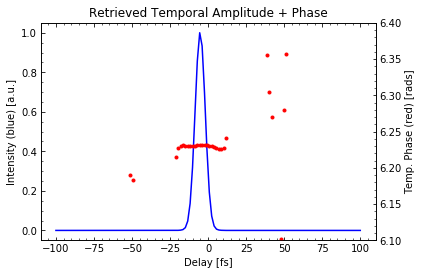

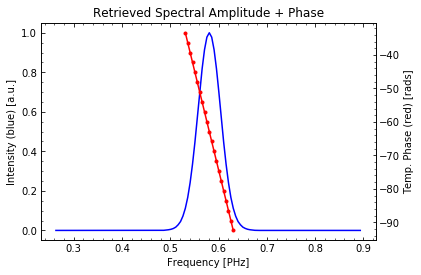

In [44]:
(tif,tphif) = frg.IP(Ef_1,0.)
(sif,sphif) = frg.IP(fft.fftshift(fft.fft(Ef_1,norm='ortho')),.1)
ax1 = plt.subplot();
intf = ax1.plot(dtst*s2fs,tif,'b')
ax2 = ax1.twinx();
phif = ax2.plot(dtst*s2fs,tphif,'r.')
# phif = ax2.plot(dtst[tst.find_ind(dtst,-50./s2fs):tst.find_ind(dtst,-10./s2fs)]*s2fs,tphif[tst.find_ind(dtst,-50./s2fs):tst.find_ind(dtst,-10./s2fs)],'r.')
ax2.set_ylim((6.1,6.4))
ax1.set_xlabel('Delay [fs]')
ax1.set_ylabel('Intensity (blue) [a.u.]')
ax2.set_ylabel('Temp. Phase (red) [rads]');
ax1.set_title('Retrieved Temporal Amplitude + Phase')
plt.figure();
ax1 = plt.subplot();
intf = ax1.plot(2*f0*h2th+ftst*h2th,sif,'b')
ax2 = ax1.twinx();
phif = ax2.plot(2*f0*h2th+ftst[sphif!=0.]*h2th,sphif[sphif!=0.],'r.-')
ax1.set_xlabel('Frequency [PHz]')
ax1.set_ylabel('Intensity (blue) [a.u.]')
ax2.set_ylabel('Temp. Phase (red) [rads]');
ax1.set_title('Retrieved Spectral Amplitude + Phase');

In [317]:
# (tif,tphif) = frg.IP(Ef_1,0.)
# ax1 = plt.subplot();
# intf = ax1.plot(dtst*s2fs,tif,'b')
# ax2 = ax1.twinx();
# phif = ax2.plot(dtst[tst.find_ind(dtst,-50./s2fs):tst.find_ind(dtst,-10./s2fs)]*s2fs,tphif[tst.find_ind(dtst,-50./s2fs):tst.find_ind(dtst,-10./s2fs)],'r.')
# ax1.set_ylabel('Intensity (blue) [a.u.]')
# ax2.set_ylabel('Temp. Phase (red) [rads]');

In [48]:
max_iter = 20
min_g = 1.e-9
Erand = rng.random(128).astype(complex)

In [49]:
(Ef_2,rtrc_2,G_2) = frg.basic_frog(trc,Erand,d_arr,max_iter,min_g)

for iteration:  1 , g =  0.0012481071341103162
for iteration:  2 , g =  0.0016634410626437286
for iteration:  3 , g =  0.002091429383880294
for iteration:  4 , g =  0.0010893262528028907
for iteration:  5 , g =  0.0009868236547469714
for iteration:  6 , g =  0.0009770403516724934
for iteration:  7 , g =  0.0009906695080848602
for iteration:  8 , g =  0.0010031854254386708
for iteration:  9 , g =  0.0010181196779152795
for iteration:  10 , g =  0.0010062692169820172
for iteration:  11 , g =  0.000990639313029287
for iteration:  12 , g =  0.0009797798728860515
for iteration:  13 , g =  0.0009834359871423253
for iteration:  14 , g =  0.0009891746560923616
for iteration:  15 , g =  0.0009912336715466189
for iteration:  16 , g =  0.001000108868122516
for iteration:  17 , g =  0.0010199228688207217
for iteration:  18 , g =  0.0010269257164939767
for iteration:  19 , g =  0.0010088097396151012
for iteration:  20 , g =  0.0010046525052710275


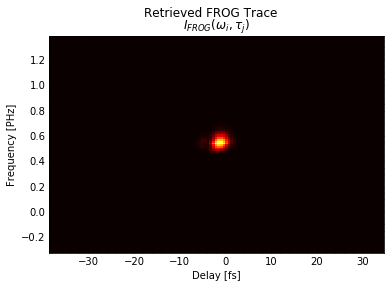

In [50]:
# plt.pcolormesh(rtrc_2);
tst.rough_plot(rtrc_2,d_arr,f_arr,title='Retrieved FROG Trace')

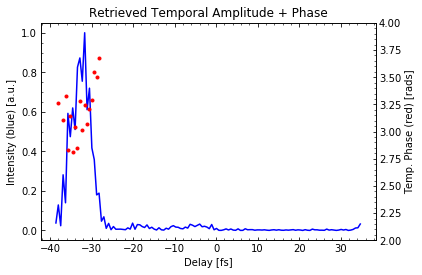

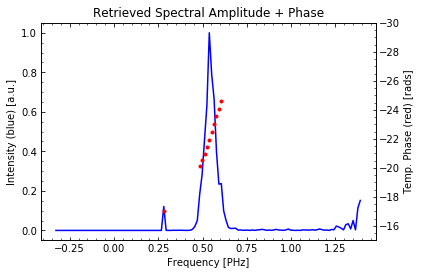

In [56]:
(tif,tphif) = frg.IP(Ef_2,.1)
(sif,sphif) = frg.IP(fft.fftshift(fft.fft(Ef_2,norm='ortho')),.1)
plt.figure();
ax1 = plt.subplot();
intf = ax1.plot(d_arr*s2fs,tif,'b')
ax2 = ax1.twinx();
phif = ax2.plot(d_arr*s2fs,tphif,'r.')
ax2.set_ylim((2.,4))
ax1.set_xlabel('Delay [fs]')
ax1.set_ylabel('Intensity (blue) [a.u.]')
ax2.set_ylabel('Temp. Phase (red) [rads]');
ax1.set_title('Retrieved Temporal Amplitude + Phase')
plt.figure();
ax1 = plt.subplot();
intf = ax1.plot(f_arr*h2th,sif,'b')
ax2 = ax1.twinx();
phif = ax2.plot(f_arr*h2th,sphif,'r.')
ax2.set_ylim((-15.,-30))
ax1.set_xlabel('Frequency [PHz]')
ax1.set_ylabel('Intensity (blue) [a.u.]')
ax2.set_ylabel('Temp. Phase (red) [rads]');
ax1.set_title('Retrieved Spectral Amplitude + Phase');

In [ ]:
# # plt.plot(Ef_2.real);
# # plt.figure();
# # plt.plot(Ef_2.imag);
# (tif2,tphif2) = frg.IP(Ef_2,.05)
# ax1 = plt.subplot();
# intf = ax1.plot(d_arr*s2fs,tif2,'b')
# ax2 = ax1.twinx();
# phif = ax2.plot(d_arr[tphif2!=0]*s2fs,tphif2[tphif2!=0],'r.')
# ax1.set_ylabel('Intensity (blue) [a.u.]')
# ax2.set_ylabel('Temp. Phase (red) [rads]');

In [57]:
(Ef_3,rtrc_3,G_3) = frg.basic_frog(trc1,Erand,d1,max_iter,min_g)

for iteration:  1 , g =  0.003592694918899317
for iteration:  2 , g =  0.0008511167641748162
for iteration:  3 , g =  0.0013875917701344502
for iteration:  4 , g =  0.0021676570526552004
for iteration:  5 , g =  0.000989363310219583
for iteration:  6 , g =  0.0007890467155471823
for iteration:  7 , g =  0.0008007924218266043
for iteration:  8 , g =  0.000868926031760678
for iteration:  9 , g =  0.0009334691190901617
for iteration:  10 , g =  0.0009829046887653565
for iteration:  11 , g =  0.0010196056206555311
for iteration:  12 , g =  0.0010472608733660526
for iteration:  13 , g =  0.0010692663123566999
for iteration:  14 , g =  0.0010874511912300614
for iteration:  15 , g =  0.0011027957025765782
for iteration:  16 , g =  0.0011173666488249053
for iteration:  17 , g =  0.0011275684010414394
for iteration:  18 , g =  0.0011384696838586039
for iteration:  19 , g =  0.0011491193647869516
for iteration:  20 , g =  0.0011520615043913388


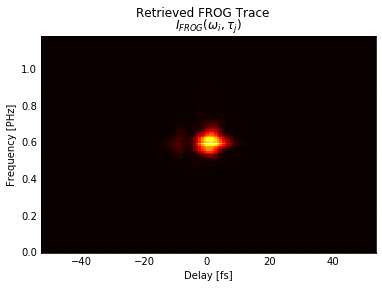

In [58]:
# plt.pcolormesh(rtrc_3)
tst.rough_plot(rtrc_3,d1,f1,title='Retrieved FROG Trace')

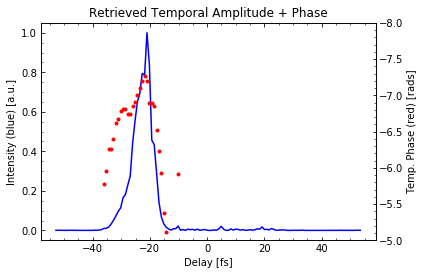

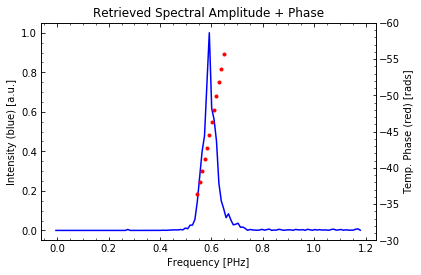

In [62]:
(tif,tphif) = frg.IP(Ef_3,.01)
(sif,sphif) = frg.IP(fft.fftshift(fft.fft(Ef_3,norm='ortho')),.1)
plt.figure();
ax1 = plt.subplot();
intf = ax1.plot(d1*s2fs,tif,'b')
ax2 = ax1.twinx();
phif = ax2.plot(d1*s2fs,tphif,'r.')
ax2.set_ylim((-5.,-8))
ax1.set_xlabel('Delay [fs]')
ax1.set_ylabel('Intensity (blue) [a.u.]')
ax2.set_ylabel('Temp. Phase (red) [rads]');
ax1.set_title('Retrieved Temporal Amplitude + Phase')
plt.figure();
ax1 = plt.subplot();
intf = ax1.plot(f1*h2th,sif,'b')
ax2 = ax1.twinx();
phif = ax2.plot(f1*h2th,sphif,'r.')
ax2.set_ylim((-30.,-60))
ax1.set_xlabel('Frequency [PHz]')
ax1.set_ylabel('Intensity (blue) [a.u.]')
ax2.set_ylabel('Temp. Phase (red) [rads]');
ax1.set_title('Retrieved Spectral Amplitude + Phase');

In [ ]:
# (tif3,tphif3) = frg.IP(Ef_3,.01)
# ax1 = plt.subplot();
# intf = ax1.plot(d1*s2fs,tif3,'b')
# ax2 = ax1.twinx();
# phif = ax2.plot(d1[tphif3!=0.]*s2fs,tphif3[tphif3!=0.],'r.')
# ax1.set_ylabel('Intensity (blue) [a.u.]')
# ax2.set_ylabel('Temp. Phase (red) [rads]');

In [63]:
(Ef_4,rtrc_4,G_4) = frg.basic_frog(trc2,Erand,d2,max_iter,min_g)

for iteration:  1 , g =  0.0021481486053417896
for iteration:  2 , g =  0.0007627814934383745
for iteration:  3 , g =  0.0015632704969657245
for iteration:  4 , g =  0.0010622048308598462
for iteration:  5 , g =  0.0010965161614042908
for iteration:  6 , g =  0.0011408739564791942
for iteration:  7 , g =  0.001135788809739724
for iteration:  8 , g =  0.0011354578997495196
for iteration:  9 , g =  0.0011328351215071889
for iteration:  10 , g =  0.0011293465863793802
for iteration:  11 , g =  0.0011233599180377528
for iteration:  12 , g =  0.0011221379959331936
for iteration:  13 , g =  0.0011306065872183824
for iteration:  14 , g =  0.0011366084626099776
for iteration:  15 , g =  0.0011392471258585392
for iteration:  16 , g =  0.0011426665705325384
for iteration:  17 , g =  0.0011483960549694733
for iteration:  18 , g =  0.0011543289817485605
for iteration:  19 , g =  0.0011567090031576544
for iteration:  20 , g =  0.0011285251489701054


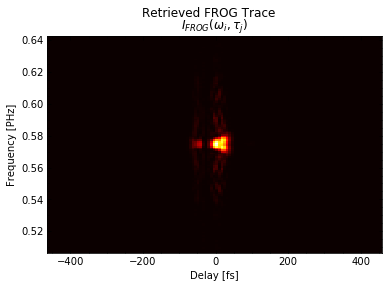

In [64]:
# plt.pcolormesh(rtrc_4)
tst.rough_plot(rtrc_4,d2,f2,title='Retrieved FROG Trace')

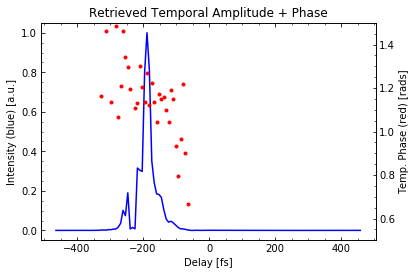

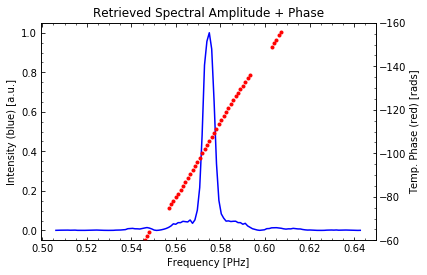

In [72]:
(tif,tphif) = frg.IP(Ef_4,.001)
(sif,sphif) = frg.IP(fft.fftshift(fft.fft(Ef_4,norm='ortho')),.01)
plt.figure();
ax1 = plt.subplot();
intf = ax1.plot(d2*s2fs,tif,'b')
ax2 = ax1.twinx();
phif = ax2.plot(d2*s2fs,tphif,'r.')
ax2.set_ylim((.5,1.5))
ax1.set_xlabel('Delay [fs]')
ax1.set_ylabel('Intensity (blue) [a.u.]')
ax2.set_ylabel('Temp. Phase (red) [rads]');
ax1.set_title('Retrieved Temporal Amplitude + Phase')
plt.figure();
ax1 = plt.subplot();
intf = ax1.plot(f2*h2th,sif,'b')
ax2 = ax1.twinx();
phif = ax2.plot(f2*h2th,sphif,'r.')
ax2.set_ylim((-60,-160.))
ax1.set_xlabel('Frequency [PHz]')
ax1.set_ylabel('Intensity (blue) [a.u.]')
ax2.set_ylabel('Temp. Phase (red) [rads]');
ax1.set_title('Retrieved Spectral Amplitude + Phase');

In [349]:
# (tif4,tphif4) = frg.IP(Ef_4,.001)
# ax1 = plt.subplot();
# intf = ax1.plot(d2*s2fs,tif4,'b')
# ax2 = ax1.twinx();
# phif = ax2.plot(d2[tphif4!=0.]*s2fs,tphif4[tphif4!=0.],'r.')
# ax1.set_ylabel('Intensity (blue) [a.u.]')
# ax2.set_ylabel('Temp. Phase (red) [rads]');

In [163]:
# double pulse offset in time with one twice as big as the others, no phase
N = 128
f0 = .2904*s2fs # carrier freq PHz
dtst = np.linspace(-60.,60.,num=N)*h2th
dt = np.diff(dtst)[0]
ftst = fft.fftshift(fft.fftfreq(N,dt))
ge1 = np.exp(-((dtst*s2fs)-10.)**2 /50.)
ge2 = .75*np.exp(-((dtst*s2fs)+5.)**2 /25.)
wv = ge1+ge2
E_true = np.array([wv[i] if (wv[i]>1.e-5) else 0. for i in range(N)],dtype=complex)
# amp and phase
(ti_true,tphi_true) = frg.IP(E_true,.001)
ftE_true = fft.fftshift(fft.fft(E_true,norm='ortho'))
(si_true,sphi_true) = frg.IP(ftE_true,.001)
# make trace
es_true = frg.pulse2sig(E_true,dtst)
ftes_true = frg.FTsig(es_true)
# ftes_true = fft.fftshift(fft.fft(es_true,axis=0,norm='ortho'),axes=0)
trc_true = frg.sig2trc(ftes_true)
trc_true /= trc_true.max()

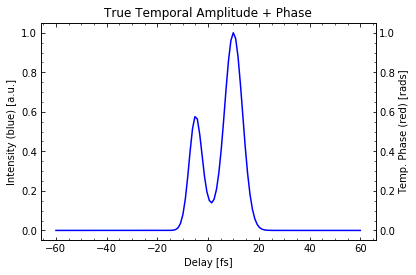

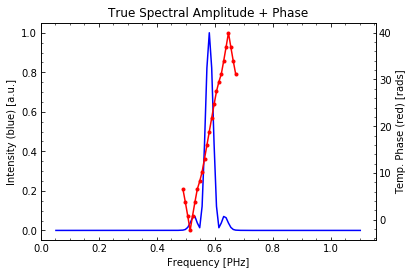

In [164]:
plt.figure();
ax1 = plt.subplot();
intf = ax1.plot(dtst*s2fs,ti_true,'b')
ax2 = ax1.twinx();
phif = ax2.plot(dtst[tphi_true!=0.]*s2fs,tphi_true[tphi_true!=0.],'r.-')
ax1.set_xlabel('Delay [fs]')
ax1.set_ylabel('Intensity (blue) [a.u.]')
ax2.set_ylabel('Temp. Phase (red) [rads]');
ax1.set_title('True Temporal Amplitude + Phase');
plt.figure();
ax1 = plt.subplot();
intf = ax1.plot(f0*2*h2th+ftst*h2th,si_true,'b')
ax2 = ax1.twinx();
phif = ax2.plot(f0*2*h2th+ftst[sphi_true!=0.]*h2th,sphi_true[sphi_true!=0.],'r.-')
ax1.set_xlabel('Frequency [PHz]')
ax1.set_ylabel('Intensity (blue) [a.u.]')
ax2.set_ylabel('Temp. Phase (red) [rads]');
ax1.set_title('True Spectral Amplitude + Phase');

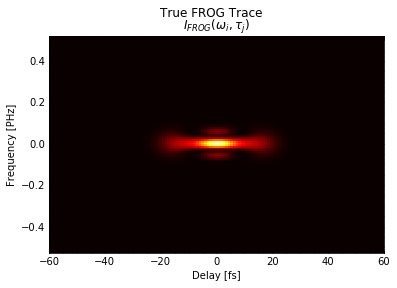

In [117]:
tst.rough_plot(trc_true,dtst,ftst,title='True FROG Trace')

In [118]:
max_iter = 20
min_g = .0001
Erand = rng.random(N).astype(complex)

In [119]:
(Ef,rtrc,G) = frg.basic_frog(trc_true,Erand,dtst,max_iter,min_g)

for iteration:  1 , g =  0.004110732642734903
for iteration:  2 , g =  0.0005146953610411322
for iteration:  3 , g =  0.0001615406877744125
for iteration:  4 , g =  0.0001894114426565384
for iteration:  5 , g =  0.0002239721370271891
for iteration:  6 , g =  0.0002192728348692678
for iteration:  7 , g =  0.0002092456739500365
for iteration:  8 , g =  0.00019180359879975305
for iteration:  9 , g =  0.00017156461147967145
for iteration:  10 , g =  0.00015102396681428138
for iteration:  11 , g =  0.00013256405218643814
for iteration:  12 , g =  0.00011776282179649694
for iteration:  13 , g =  0.00010616845483633009
for iteration:  14 , g =  9.632201786007543e-05
Yay pulse retrived in  14  iterations!


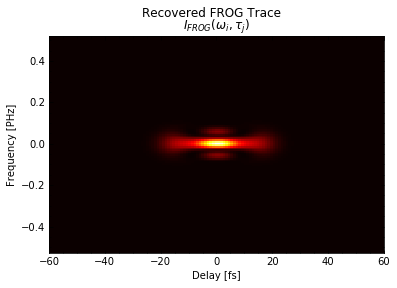

In [120]:
tst.rough_plot(rtrc,dtst,ftst,title='Recovered FROG Trace')

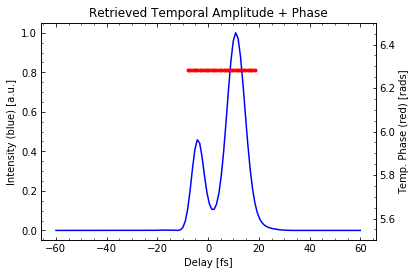

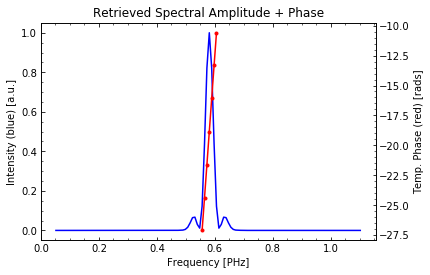

In [122]:
(tif,tphif) = frg.IP(Ef,.1)
(sif,sphif) = frg.IP(fft.fftshift(fft.fft(Ef,norm='ortho')),.1)
plt.figure();
ax1 = plt.subplot();
intf = ax1.plot(dtst*s2fs,tif,'b')
ax2 = ax1.twinx();
phif = ax2.plot(dtst*s2fs,tphif,'r.')
ax2.set_ylim((5.5,6.5))
ax1.set_xlabel('Delay [fs]')
ax1.set_ylabel('Intensity (blue) [a.u.]')
ax2.set_ylabel('Temp. Phase (red) [rads]');
ax1.set_title('Retrieved Temporal Amplitude + Phase')
plt.figure();
ax1 = plt.subplot();
intf = ax1.plot(2*f0*h2th+ftst*h2th,sif,'b')
ax2 = ax1.twinx();
phif = ax2.plot(2*f0*h2th+ftst[sphif!=0.]*h2th,sphif[sphif!=0.],'r.-')
ax1.set_xlabel('Frequency [PHz]')
ax1.set_ylabel('Intensity (blue) [a.u.]')
ax2.set_ylabel('Temp. Phase (red) [rads]');
ax1.set_title('Retrieved Spectral Amplitude + Phase');

In [151]:
# single pulse with cubic phase
N = 128
f0 = .2904*s2fs # carrier freq PHz
dtst = np.linspace(-100.,100.,num=N)*h2th
dt = np.diff(dtst)[0]
ftst = fft.fftshift(fft.fftfreq(N,dt))
ge = np.exp(-((dtst*s2fs))**2 /500.)
cp = np.exp(1j*1.e-5*(dtst*s2fs)**3)
wv = ge*cp
E_true = np.array([wv[i] if (wv[i]>1.e-5) else 0. for i in range(N)],dtype=complex)
# amp and phase
(ti_true,tphi_true) = frg.IP(E_true,.001)
ftE_true = fft.fftshift(fft.fft(E_true,norm='ortho'))
(si_true,sphi_true) = frg.IP(ftE_true,.001)
# make trace
es_true = frg.pulse2sig(E_true,dtst)
ftes_true = frg.FTsig(es_true)
trc_true = frg.sig2trc(ftes_true)
trc_true /= trc_true.max()

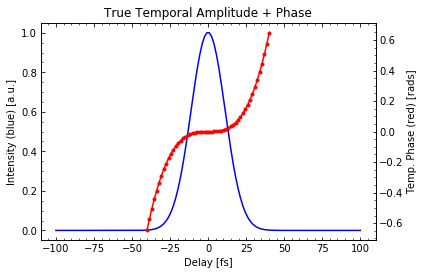

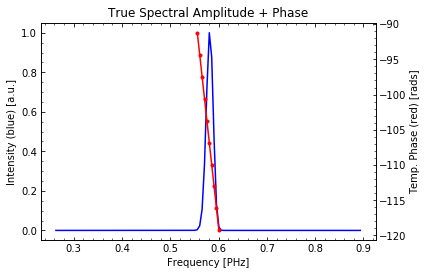

In [152]:
plt.figure();
ax1 = plt.subplot();
intf = ax1.plot(dtst*s2fs,ti_true,'b')
ax2 = ax1.twinx();
phif = ax2.plot(dtst[tphi_true!=0.]*s2fs,tphi_true[tphi_true!=0.],'r.-')
ax1.set_xlabel('Delay [fs]')
ax1.set_ylabel('Intensity (blue) [a.u.]')
ax2.set_ylabel('Temp. Phase (red) [rads]');
ax1.set_title('True Temporal Amplitude + Phase');
plt.figure();
ax1 = plt.subplot();
intf = ax1.plot(f0*2*h2th+ftst*h2th,si_true,'b')
ax2 = ax1.twinx();
phif = ax2.plot(f0*2*h2th+ftst[sphi_true!=0.]*h2th,sphi_true[sphi_true!=0.],'r.-')
ax1.set_xlabel('Frequency [PHz]')
ax1.set_ylabel('Intensity (blue) [a.u.]')
ax2.set_ylabel('Temp. Phase (red) [rads]');
ax1.set_title('True Spectral Amplitude + Phase');

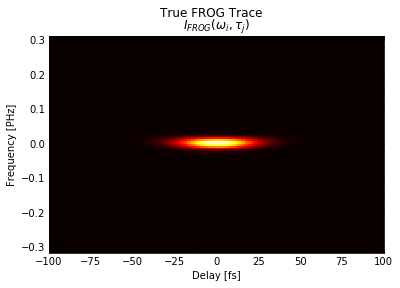

In [153]:
tst.rough_plot(trc_true,dtst,ftst,title='True FROG Trace')

In [154]:
max_iter = 20
min_g = .0001
Erand = rng.random(N).astype(complex)

In [155]:
(Ef,rtrc,G) = frg.basic_frog(trc_true,Erand,dtst,max_iter,min_g)

for iteration:  1 , g =  0.002824684614095119
for iteration:  2 , g =  0.0019483808074236655
for iteration:  3 , g =  0.0004978410828749286
for iteration:  4 , g =  6.200973678466992e-05
Yay pulse retrived in  4  iterations!


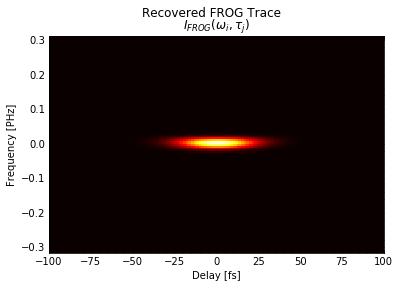

In [156]:
tst.rough_plot(rtrc,dtst,ftst,title='Recovered FROG Trace')

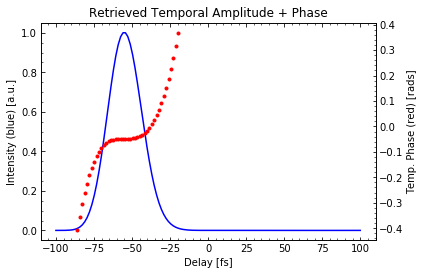

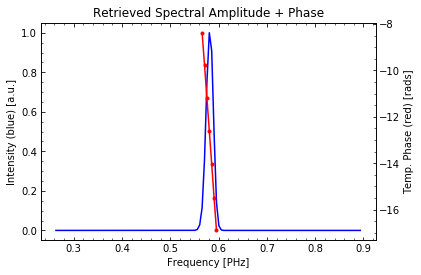

In [160]:
(tif,tphif) = frg.IP(Ef,.01)
(sif,sphif) = frg.IP(fft.fftshift(fft.fft(Ef,norm='ortho')),.1)
plt.figure();
ax1 = plt.subplot();
intf = ax1.plot(dtst*s2fs,tif,'b')
ax2 = ax1.twinx();
phif = ax2.plot(dtst[tphif!=0.]*s2fs,tphif[tphif!=0.],'r.')
# ax2.set_ylim((5.5,6.5))
ax1.set_xlabel('Delay [fs]')
ax1.set_ylabel('Intensity (blue) [a.u.]')
ax2.set_ylabel('Temp. Phase (red) [rads]');
ax1.set_title('Retrieved Temporal Amplitude + Phase')
plt.figure();
ax1 = plt.subplot();
intf = ax1.plot(2*f0*h2th+ftst*h2th,sif,'b')
ax2 = ax1.twinx();
phif = ax2.plot(2*f0*h2th+ftst[sphif!=0.]*h2th,sphif[sphif!=0.],'r.-')
ax1.set_xlabel('Frequency [PHz]')
ax1.set_ylabel('Intensity (blue) [a.u.]')
ax2.set_ylabel('Temp. Phase (red) [rads]');
ax1.set_title('Retrieved Spectral Amplitude + Phase');

In [225]:
# double pulse offset in time with one twice as big as the others, cubic phase
N = 128
f0 = .2904*s2fs # carrier freq PHz
dtst = np.linspace(-200.,200.,num=N)*h2th
dt = np.diff(dtst)[0]
ftst = fft.fftshift(fft.fftfreq(N,dt))
ge1 = np.exp(-((dtst*s2fs)-30.)**2 /500.)
ge2 = .5*np.exp(-((dtst*s2fs)+20.)**2 /250.)
cp = np.exp(1j*1.e-5*(dtst*s2fs)**3)
wv = (ge1+ge2)*cp
E_true = np.array([wv[i] if (wv[i]>1.e-5) else 0. for i in range(N)],dtype=complex)
# amp and phase
(ti_true,tphi_true) = frg.IP(E_true,.001)
ftE_true = fft.fftshift(fft.fft(E_true,norm='ortho'))
(si_true,sphi_true) = frg.IP(ftE_true,.001)
# make trace
es_true = frg.pulse2sig(E_true,dtst)
ftes_true = frg.FTsig(es_true)
trc_true = frg.sig2trc(ftes_true)
trc_true /= trc_true.max()

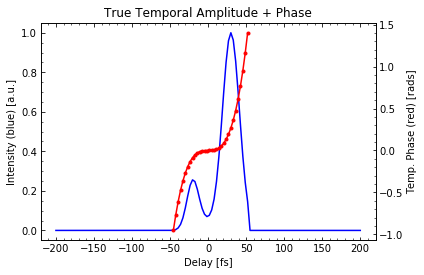

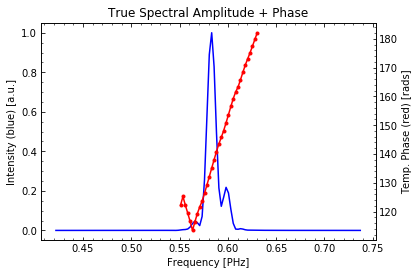

In [227]:
plt.figure();
ax1 = plt.subplot();
intf = ax1.plot(dtst*s2fs,ti_true,'b')
ax2 = ax1.twinx();
phif = ax2.plot(dtst[tphi_true!=0.]*s2fs,tphi_true[tphi_true!=0.],'r.-')
ax1.set_xlabel('Delay [fs]')
ax1.set_ylabel('Intensity (blue) [a.u.]')
ax2.set_ylabel('Temp. Phase (red) [rads]');
ax1.set_title('True Temporal Amplitude + Phase');
plt.figure();
ax1 = plt.subplot();
intf = ax1.plot(f0*2*h2th+ftst*h2th,si_true,'b')
ax2 = ax1.twinx();
phif = ax2.plot(f0*2*h2th+ftst[sphi_true!=0.]*h2th,sphi_true[sphi_true!=0.],'r.-')
ax1.set_xlabel('Frequency [PHz]')
ax1.set_ylabel('Intensity (blue) [a.u.]')
ax2.set_ylabel('Temp. Phase (red) [rads]');
ax1.set_title('True Spectral Amplitude + Phase');

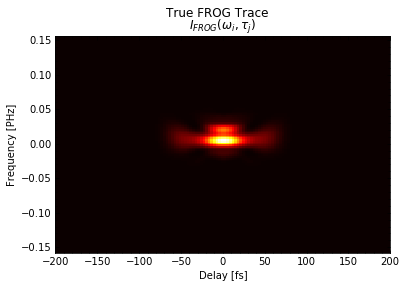

In [181]:
tst.rough_plot(trc_true,dtst,ftst,title='True FROG Trace')

In [182]:
max_iter = 20
min_g = .0001
Erand = rng.random(N).astype(complex)

In [183]:
(Ef,rtrc,G) = frg.basic_frog(trc_true,Erand,dtst,max_iter,min_g)

for iteration:  1 , g =  0.006900440514302953
for iteration:  2 , g =  0.0005347563297209145
for iteration:  3 , g =  0.0005405686929310702
for iteration:  4 , g =  0.0004042790575901569
for iteration:  5 , g =  0.0003127582951927333
for iteration:  6 , g =  0.00021258633974065465
for iteration:  7 , g =  0.00013440648838995513
for iteration:  8 , g =  7.664411053498089e-05
Yay pulse retrived in  8  iterations!


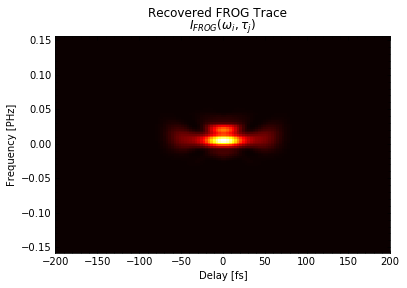

In [184]:
tst.rough_plot(rtrc,dtst,ftst,title='Recovered FROG Trace')

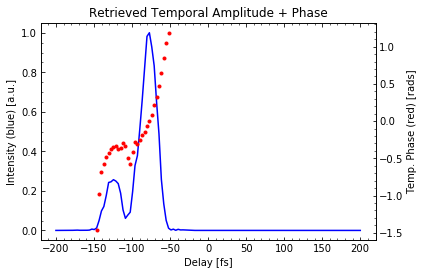

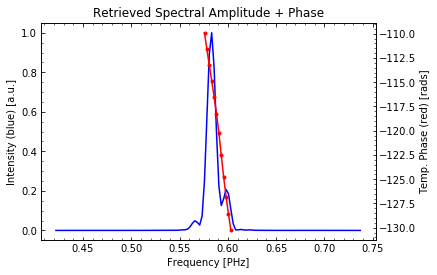

In [185]:
(tif,tphif) = frg.IP(Ef,.01)
(sif,sphif) = frg.IP(fft.fftshift(fft.fft(Ef,norm='ortho')),.1)
plt.figure();
ax1 = plt.subplot();
intf = ax1.plot(dtst*s2fs,tif,'b')
ax2 = ax1.twinx();
phif = ax2.plot(dtst[tphif!=0.]*s2fs,tphif[tphif!=0.],'r.')
# ax2.set_ylim((5.5,6.5))
ax1.set_xlabel('Delay [fs]')
ax1.set_ylabel('Intensity (blue) [a.u.]')
ax2.set_ylabel('Temp. Phase (red) [rads]');
ax1.set_title('Retrieved Temporal Amplitude + Phase')
plt.figure();
ax1 = plt.subplot();
intf = ax1.plot(2*f0*h2th+ftst*h2th,sif,'b')
ax2 = ax1.twinx();
phif = ax2.plot(2*f0*h2th+ftst[sphif!=0.]*h2th,sphif[sphif!=0.],'r.-')
ax1.set_xlabel('Frequency [PHz]')
ax1.set_ylabel('Intensity (blue) [a.u.]')
ax2.set_ylabel('Temp. Phase (red) [rads]');
ax1.set_title('Retrieved Spectral Amplitude + Phase');

In [198]:
# single pulse with linear chirp
N = 128
f0 = .2904*s2fs # carrier freq PHz
dtst = np.linspace(-100.,100.,num=N)*h2th
dt = np.diff(dtst)[0]
ftst = fft.fftshift(fft.fftfreq(N,dt))
ge = np.exp(-((dtst*s2fs))**2 /300.)
cp = np.exp(1j*1.e-3*(dtst*s2fs)**2)
wv = ge*cp
E_true = np.array([wv[i] if (wv[i]>1.e-5) else 0. for i in range(N)],dtype=complex)
# amp and phase
(ti_true,tphi_true) = frg.IP(E_true,.001)
ftE_true = fft.fftshift(fft.fft(E_true,norm='ortho'))
(si_true,sphi_true) = frg.IP(ftE_true,.001)
# make trace
es_true = frg.pulse2sig(E_true,dtst)
ftes_true = frg.FTsig(es_true)
trc_true = frg.sig2trc(ftes_true)
trc_true /= trc_true.max()

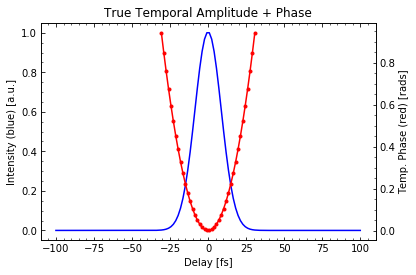

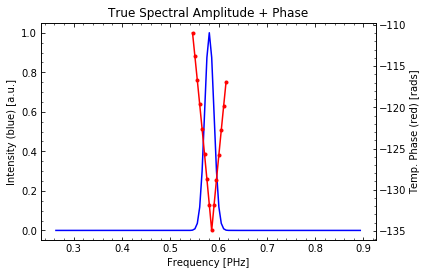

In [199]:
plt.figure();
ax1 = plt.subplot();
intf = ax1.plot(dtst*s2fs,ti_true,'b')
ax2 = ax1.twinx();
phif = ax2.plot(dtst[tphi_true!=0.]*s2fs,tphi_true[tphi_true!=0.],'r.-')
ax1.set_xlabel('Delay [fs]')
ax1.set_ylabel('Intensity (blue) [a.u.]')
ax2.set_ylabel('Temp. Phase (red) [rads]');
ax1.set_title('True Temporal Amplitude + Phase');
plt.figure();
ax1 = plt.subplot();
intf = ax1.plot(f0*2*h2th+ftst*h2th,si_true,'b')
ax2 = ax1.twinx();
phif = ax2.plot(f0*2*h2th+ftst[sphi_true!=0.]*h2th,sphi_true[sphi_true!=0.],'r.-')
ax1.set_xlabel('Frequency [PHz]')
ax1.set_ylabel('Intensity (blue) [a.u.]')
ax2.set_ylabel('Temp. Phase (red) [rads]');
ax1.set_title('True Spectral Amplitude + Phase');

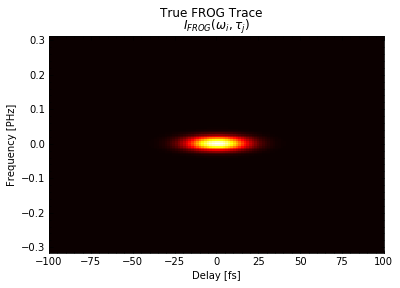

In [200]:
tst.rough_plot(trc_true,dtst,ftst,title='True FROG Trace')

In [201]:
max_iter = 20
min_g = .0001
Erand = rng.random(N).astype(complex)

In [202]:
(Ef,rtrc,G) = frg.basic_frog(trc_true,Erand,dtst,max_iter,min_g)

for iteration:  1 , g =  0.004719320688691024
for iteration:  2 , g =  0.00337118009985765
for iteration:  3 , g =  0.0012865002731162968
for iteration:  4 , g =  0.00024542643910341913
for iteration:  5 , g =  0.0001225378904147334
for iteration:  6 , g =  0.00014734360458244907
for iteration:  7 , g =  0.00015262325063133424
for iteration:  8 , g =  0.00015405012120176334
for iteration:  9 , g =  0.00015409181541919964
for iteration:  10 , g =  0.0001534793963129268
for iteration:  11 , g =  0.00015251851261426091
for iteration:  12 , g =  0.0001513622592022164
for iteration:  13 , g =  0.00015009919223220506
for iteration:  14 , g =  0.00014878723362851326
for iteration:  15 , g =  0.00014746866315566828
for iteration:  16 , g =  0.00014617684403484812
for iteration:  17 , g =  0.0001449385254263311
for iteration:  18 , g =  0.00014377599624374203
for iteration:  19 , g =  0.00014270951081148892
for iteration:  20 , g =  0.0001417495666359865


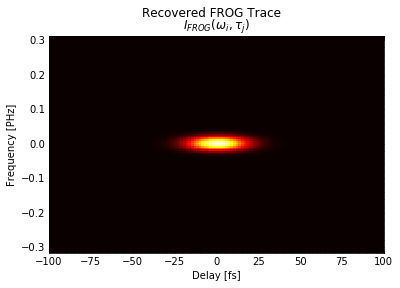

In [203]:
tst.rough_plot(rtrc,dtst,ftst,title='Recovered FROG Trace')

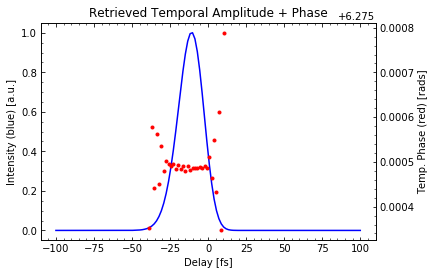

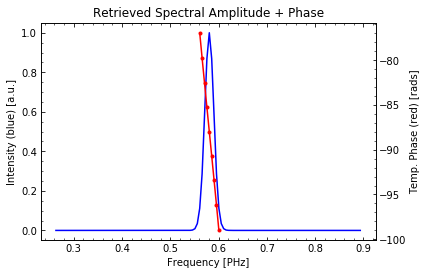

In [204]:
(tif,tphif) = frg.IP(Ef,.01)
(sif,sphif) = frg.IP(fft.fftshift(fft.fft(Ef,norm='ortho')),.1)
plt.figure();
ax1 = plt.subplot();
intf = ax1.plot(dtst*s2fs,tif,'b')
ax2 = ax1.twinx();
phif = ax2.plot(dtst[tphif!=0.]*s2fs,tphif[tphif!=0.],'r.')
# ax2.set_ylim((5.5,6.5))
ax1.set_xlabel('Delay [fs]')
ax1.set_ylabel('Intensity (blue) [a.u.]')
ax2.set_ylabel('Temp. Phase (red) [rads]');
ax1.set_title('Retrieved Temporal Amplitude + Phase')
plt.figure();
ax1 = plt.subplot();
intf = ax1.plot(2*f0*h2th+ftst*h2th,sif,'b')
ax2 = ax1.twinx();
phif = ax2.plot(2*f0*h2th+ftst[sphif!=0.]*h2th,sphif[sphif!=0.],'r.-')
ax1.set_xlabel('Frequency [PHz]')
ax1.set_ylabel('Intensity (blue) [a.u.]')
ax2.set_ylabel('Temp. Phase (red) [rads]');
ax1.set_title('Retrieved Spectral Amplitude + Phase');

In [213]:
# single pulse with linear chirp, with noise
N = 128
f0 = .2904*s2fs # carrier freq PHz
dtst = np.linspace(-100.,100.,num=N)*h2th
dt = np.diff(dtst)[0]
ftst = fft.fftshift(fft.fftfreq(N,dt))
ge = np.exp(-((dtst*s2fs))**2 /300.)
cp = np.exp(1j*1.e-3*(dtst*s2fs)**2)
wv = ge*cp
E_true = np.array([wv[i] if (wv[i]>1.e-5) else 0. for i in range(N)],dtype=complex)
# amp and phase
(ti_true,tphi_true) = frg.IP(E_true,.001)
ftE_true = fft.fftshift(fft.fft(E_true,norm='ortho'))
(si_true,sphi_true) = frg.IP(ftE_true,.001)
# make trace
es_true = frg.pulse2sig(E_true,dtst)
ftes_true = frg.FTsig(es_true)
trc_true = frg.sig2trc(ftes_true)
trc_true /= trc_true.max()
# fuck it up girlie
eta = (etaij*alpha)/etaij.max()
trc_noise = trc_true+eta

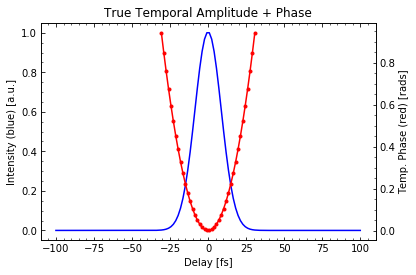

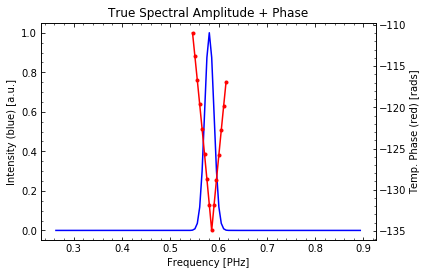

In [214]:
plt.figure();
ax1 = plt.subplot();
intf = ax1.plot(dtst*s2fs,ti_true,'b')
ax2 = ax1.twinx();
phif = ax2.plot(dtst[tphi_true!=0.]*s2fs,tphi_true[tphi_true!=0.],'r.-')
ax1.set_xlabel('Delay [fs]')
ax1.set_ylabel('Intensity (blue) [a.u.]')
ax2.set_ylabel('Temp. Phase (red) [rads]');
ax1.set_title('True Temporal Amplitude + Phase');
plt.figure();
ax1 = plt.subplot();
intf = ax1.plot(f0*2*h2th+ftst*h2th,si_true,'b')
ax2 = ax1.twinx();
phif = ax2.plot(f0*2*h2th+ftst[sphi_true!=0.]*h2th,sphi_true[sphi_true!=0.],'r.-')
ax1.set_xlabel('Frequency [PHz]')
ax1.set_ylabel('Intensity (blue) [a.u.]')
ax2.set_ylabel('Temp. Phase (red) [rads]');
ax1.set_title('True Spectral Amplitude + Phase');

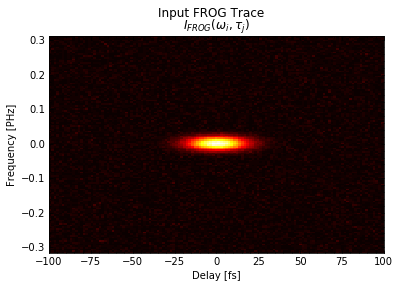

In [215]:
tst.rough_plot(trc_noise,dtst,ftst,title='Input FROG Trace')

In [220]:
max_iter = 20
min_g = .0001
Erand = rng.random(N).astype(complex)

In [221]:
(Ef,rtrc,G) = frg.basic_frog(trc_true,Erand,dtst,max_iter,min_g)

for iteration:  1 , g =  0.004146565251438635
for iteration:  2 , g =  0.0008190393611636813
for iteration:  3 , g =  6.243569311550287e-05
Yay pulse retrived in  3  iterations!


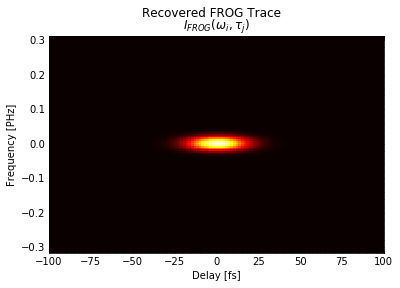

In [222]:
tst.rough_plot(rtrc,dtst,ftst,title='Recovered FROG Trace')

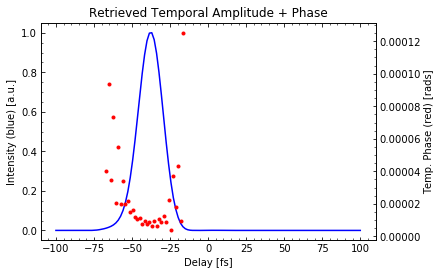

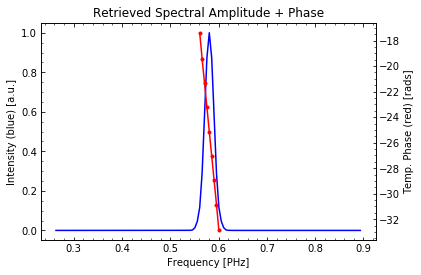

In [223]:
(tif,tphif) = frg.IP(Ef,.01)
(sif,sphif) = frg.IP(fft.fftshift(fft.fft(Ef,norm='ortho')),.1)
plt.figure();
ax1 = plt.subplot();
intf = ax1.plot(dtst*s2fs,tif,'b')
ax2 = ax1.twinx();
phif = ax2.plot(dtst[tphif!=0.]*s2fs,tphif[tphif!=0.],'r.')
# ax2.set_ylim((5.5,6.5))
ax1.set_xlabel('Delay [fs]')
ax1.set_ylabel('Intensity (blue) [a.u.]')
ax2.set_ylabel('Temp. Phase (red) [rads]');
ax1.set_title('Retrieved Temporal Amplitude + Phase')
plt.figure();
ax1 = plt.subplot();
intf = ax1.plot(2*f0*h2th+ftst*h2th,sif,'b')
ax2 = ax1.twinx();
phif = ax2.plot(2*f0*h2th+ftst[sphif!=0.]*h2th,sphif[sphif!=0.],'r.-')
ax1.set_xlabel('Frequency [PHz]')
ax1.set_ylabel('Intensity (blue) [a.u.]')
ax2.set_ylabel('Temp. Phase (red) [rads]');
ax1.set_title('Retrieved Spectral Amplitude + Phase');